# Cropping Demo
This demo showcases how to crop images to either anatomic (e.g. brain, breast) or region-of-interest (ROI) masks using `TumorTwin`.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from pydantic import FilePath

from tumortwin.preprocessing import ADC_to_cellularity
from tumortwin.types import CropSettings, CropTarget, HGGPatientData
from tumortwin.utils import find_best_slice

try:
    patient_dir = os.environ.get("patient_dir")
    image_dir = os.environ.get("image_dir")
    assert patient_dir is not None
    assert image_dir is not None
    PATIENT_INFO_PATH = FilePath(patient_dir)
    IMAGE_PATH = Path(image_dir)
except:
    raise ValueError("Missing environment variables! Check .env file")

Let's start by loading in the patient dataset. `crop_settings=None` (the default) will perform no cropping. Let's visualize the data by plotting a slice of the brain, and overlay the brain mask.

Array size: (90, 116, 36)
Number of elements: 375840


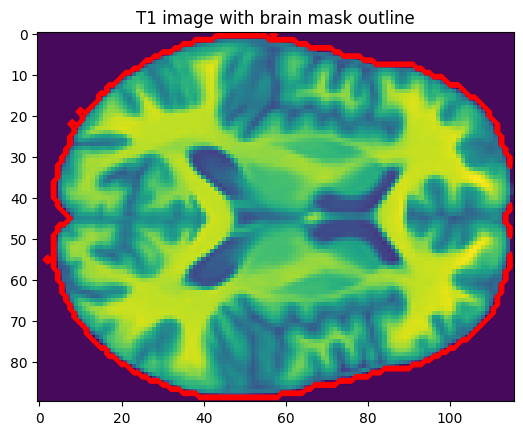

Array size: (90, 116, 36)
Number of elements: 375840


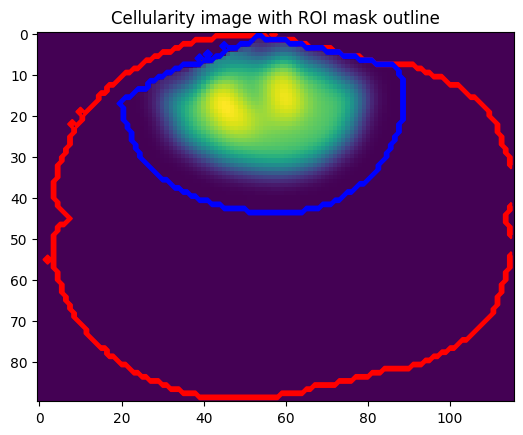

In [2]:
patient_data = HGGPatientData.from_file(
    PATIENT_INFO_PATH, image_dir=IMAGE_PATH, crop_settings=None
)

visit = patient_data.visits[0]

cellularity = ADC_to_cellularity(
    visit.adc_image, visit.roi_enhance_image, visit.roi_nonenhance_image
)

slice_idx = find_best_slice(cellularity.array)

fig, ax = plt.subplots(1, 1)
ax.imshow(patient_data.T1_pre_image.array[:, :, slice_idx])
ax.contour(patient_data.brainmask_image.array[:, :, slice_idx], colors="red")
ax.set_title("T1 image with brain mask outline")
print(f"Array size: {cellularity.array.shape}")
print(f"Number of elements: {cellularity.array.size}")
plt.show()

fig, ax = plt.subplots(1, 1)
ax.imshow(cellularity.array[:, :, slice_idx])
ax.contour(patient_data.brainmask_image.array[:, :, slice_idx], colors="red")
ax.contour(visit.roi_enhance_image.array[:, :, slice_idx], colors="blue")
ax.set_title("Cellularity image with ROI mask outline")
print(f"Array size: {cellularity.array.shape}")
print(f"Number of elements: {cellularity.array.size}")

This image is from an atlas, so has already been cropped to the brain region. In general this will not be the case, so we can perform cropping by setting the `CropSettings` object to have `crop_to=CropTarget.ANATOMY`:

Array size after cropping to brain: (90, 116, 36)
Number of elements: 375840
Reduction in number of elements: 0.0%


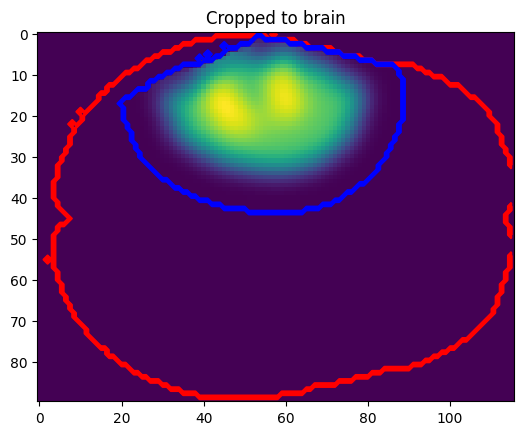

In [3]:
patient_data_brain_crop = HGGPatientData.from_file(
    PATIENT_INFO_PATH,
    image_dir=IMAGE_PATH,
    crop_settings=CropSettings(crop_to=CropTarget.ANATOMY),
)
visit = patient_data_brain_crop.visits[0]

cellularity_brain_crop = ADC_to_cellularity(
    visit.adc_image, visit.roi_enhance_image, visit.roi_nonenhance_image
)

fig, ax = plt.subplots(1, 1)
ax.imshow(cellularity_brain_crop.array[:, :, slice_idx])
ax.contour(patient_data_brain_crop.brainmask_image.array[:, :, slice_idx], colors="red")
ax.contour(visit.roi_enhance_image.array[:, :, slice_idx], colors="blue")
ax.set_title("Cropped to brain")
print(f"Array size after cropping to brain: {cellularity_brain_crop.array.shape}")
print(f"Number of elements: {cellularity_brain_crop.array.size}")
print(
    f"Reduction in number of elements: {(1 - (cellularity_brain_crop.array.size / cellularity.array.size))*100:.1f}%"
)

Sometimes, if the tumor only occupies a small region in the brain, we may not want to include the entire brain in our computational domain. Instead, we may like to use only a region-of-interest (ROI), potentially with additional padding to allow for some amount of future tumor growth outside the ROI. 

We can achieve this by using 
`crop_settings = CropSettings(crop_to = CropTarget.ROI_ENHANCE, padding = 0, visit_index = -1)`
Note that the visit_index is used to specify which imaging visit's ROI to use. You would typically choose the largest ROI - here we use `-1`, the last visit, since this particular tumor is growing in time. For a shrinking tumor you might choose `visit_index = 0`.

Array size after cropping to ROI: (62, 105, 34)
Number of elements: 221340
Reduction in number of elements: 41.1%


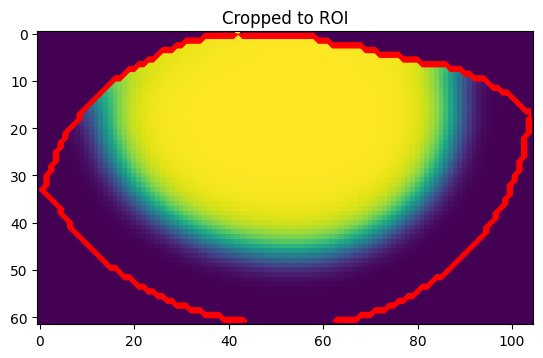

In [4]:
patient_data_roi_crop = HGGPatientData.from_file(
    PATIENT_INFO_PATH,
    image_dir=IMAGE_PATH,
    crop_settings=CropSettings(
        crop_to=CropTarget.ROI_ENHANCE, padding=0, visit_index=-1
    ),
)
visit = patient_data_roi_crop.visits[patient_data_roi_crop.crop_settings.visit_index]

cellularity_roi_crop = ADC_to_cellularity(
    visit.adc_image, visit.roi_enhance_image, visit.roi_nonenhance_image
)

fig, ax = plt.subplots(1, 1)
ax.imshow(cellularity_roi_crop.array[:, :, slice_idx])
ax.contour(visit.roi_enhance_image.array[:, :, slice_idx], colors="red")
ax.set_title("Cropped to ROI")
print(f"Array size after cropping to ROI: {cellularity_roi_crop.array.shape}")
print(f"Number of elements: {cellularity_roi_crop.array.size}")
print(
    f"Reduction in number of elements: {(1 - (cellularity_roi_crop.array.size / cellularity.array.size))*100:.1f}%"
)

# Conclusion: 
This demonstrates the `TumorTwin` cropping functionality. Since the computational domain is three-dimensional, cropping to only the relevant region can greatly reduce the number of degrees of freedom in the solution domain, leading to large computational savings.